# Analysis of hourly meteorological data from Canary Island stations

## 1. Overview

In this notebook, we perform an analysis of data collected from meteorological stations placed in Canary Islands. These stations are included in the United States Air Force (USAF) Master Station Catalog and registered in the National Climatic Data Center's (NCDC) archive of weather and climate data. For a given station, we can collect information by providing beginning and ending years.
In this case, we consider a R library called stationaRy ([Iannone R., 2015](#iannone)) as well as the dplyr ([Wickham H. et al., 2017](#wickham_et_al)) and ggplot2 ([Wickham H., 2009](#wickham1)) libraries.


In [1]:
usePackage <- function(p) {
  if (!is.element(p, installed.packages()[,1]))
    install.packages(p, dep = TRUE)
  require(p, character.only = TRUE) }
    
usePackage("stationaRy")
usePackage("dplyr")
usePackage("ggplot2")
usePackage("ggmap")

Loading required package: stationaRy
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: ggmap


## 2. Selecting stations and loading data

To obtain data stations of the Canary Islands, we can use the the get_isd_stations() function of stationaRy library. This function returns a data frame with information on hourly meteorological station specifying a geographical bounding box and/or time bounds. An appropriate filter is specified to find the stations of the Canarys. Among others, we get the latitude and longitude postion of station, the earliest and latest year for which data are available and the country where the station is located.

In [2]:
# Get data of all stations in Canary Islands
stations_canary <- 
  get_isd_stations() %>% 
  filter(country == "SP" & iso3166_2_subd=="CN")
stations_canary

usaf,wban,name,country,state,lat,lon,elev,begin,end,gmt_offset,time_zone_id,country_name,country_code,iso3166_2_subd,fips10_4_subd
600010,99999,HIERRO,SP,,27.815,-17.887,31.4,1973,2015,0,Atlantic/Canary,Spain,ES,CN,53
600050,99999,LA PALMA,SP,,28.626,-17.756,32.6,1960,2015,0,Atlantic/Canary,Spain,ES,CN,53
600070,99999,LA GOMERA/AEROPUERTO,SP,,28.033,-17.217,219.0,2004,2015,0,Atlantic/Canary,Spain,ES,CN,53
600100,99999,IZANA,SP,,28.317,-16.500,2368.0,1947,2015,0,Atlantic/Canary,Spain,ES,CN,53
600150,99999,TENERIFE NORTE,SP,,28.483,-16.342,631.9,1947,2015,0,Atlantic/Canary,Spain,ES,CN,53
600180,99999,TENERIFE-GUIMAR,SP,,28.317,-16.383,111.0,2008,2008,0,Atlantic/Canary,Spain,ES,CN,53
600200,99999,STA. CRUZ DE TENERIFE,SP,,28.450,-16.250,36.0,1931,2015,0,Atlantic/Canary,Spain,ES,CN,53
600250,99999,TENERIFE SUR,SP,,28.044,-16.572,63.7,1980,2015,0,Atlantic/Canary,Spain,ES,CN,53
600280,99999,ARTENARA,SP,,28.017,-15.617,1681.0,2004,2006,0,Atlantic/Canary,Spain,ES,CN,53
600300,99999,GRAN CANARIA,SP,,27.932,-15.387,23.8,1950,2015,0,Atlantic/Canary,Spain,ES,CN,53


## 3. Visualizing the geographical position of stations 

With the library ggmap ([Kahle D. and Wickham H., 2013](#kahle_wickham)) we query over different possible internet sources (Google Maps, OpenStreetMap, Stamen Maps or Naver Map servers) to get a map. In our case, we use the function get_googlemap() of the library to obtain a map of the archipelago of the Canary Islands from Google Maps.

In [3]:
suppressMessages(library(ggmap))
#map <- get_map(location = 'Canary Islands', zoom = 7, maptype = "terrain")
map <- get_googlemap(center = c(-16,28.5), zoom = 7, maptype = "terrain",
                     style = c(feature = "all", element = "labels", visibility = "off"))

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=28.5,-16&zoom=7&size=640x640&scale=2&maptype=terrain&style=feature:all%7Celement:labels%7Cvisibility:off&sensor=false


The stations are placed in a map and we put a label for each one (using an offset to avoid the overlapping) 

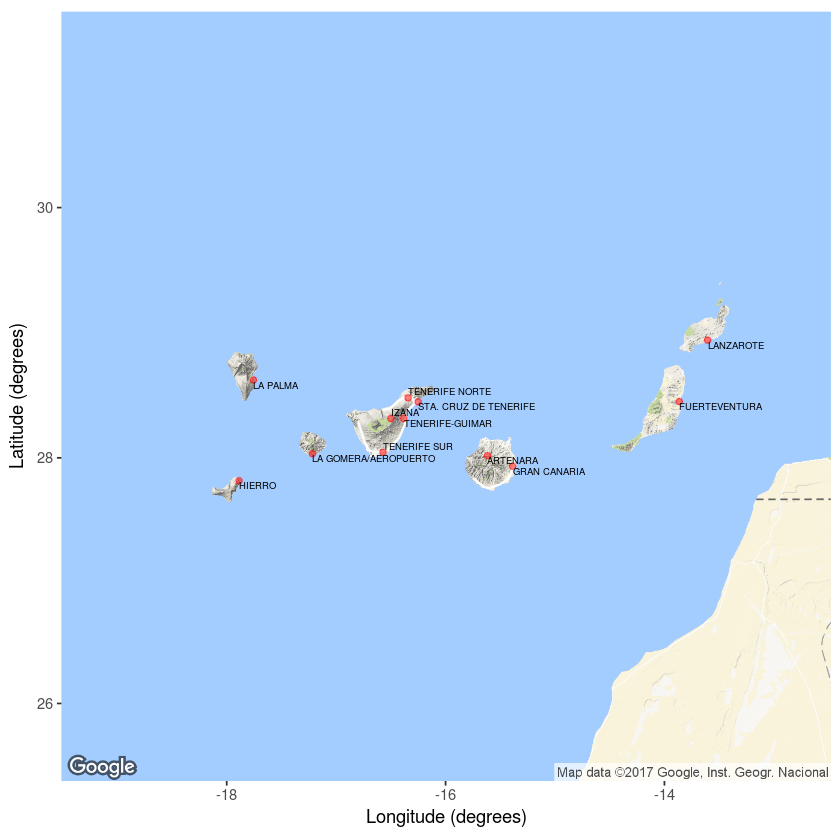

In [4]:
stations_canary$offset<--0.04
stations_canary$offset[stations_canary$name %in% c("IZANA","TENERIFE NORTE","TENERIFE SUR")]<-0.05

mapPoints <- ggmap(map) +
    geom_point(aes(x = lon, y = lat), data = stations_canary, col="red", alpha = .5) +
    geom_text(aes(x = lon, y = lat+offset, label=name), data = stations_canary, size = 2.0, hjust="left")+
    xlab("Longitude (degrees)") + ylab("Latitude (degrees)")
print(mapPoints)

## 4. Get data from a particular station

We are interested in study the weather conditions in 2017 in Teide National Park, that is located in Tenerife island. The nearest station where obtain the data for this study corresponds to Izaña Atmospheric Observatory at 2400 meters above sea level. 

<img src="izana_observatory.jpg" alt="Izaña Atmospheric Observatory" style="width:304px;height:228px;">

In the following code, the funtion get_isd_station_data() of the stationaRy library is used in order to obtain several data of Izaña station. In particular, we get hourly information about time, wind seeed and direction, and temperature along 2017 year.
In the library documentation are described the methods for obtaining another meteorological variables of interest.

In [5]:
loadFromInternet<-FALSE
if(loadFromInternet) {
  temps_at_izana <-
    get_isd_stations() %>%
    #filter(name == "IZANA") %>%
    select_isd_station(name = "IZANA") %>%
    get_isd_station_data(startyear = 2017, endyear = 2017) %>%
    select(time, wd, ws, temp) %>% 
    rename(wind_speed=ws,wind_direction=wd)
} else {
    cat("Loading data from local file")
    load("temps_at_izana.RData")
  }


Loading data from local file

In [6]:
temps_at_izana$time<-as.POSIXct(strptime(temps_at_izana$time,format="%Y-%m-%d %H:%M:%S"),format="%Y-%m-%d %H:%M:%S")
head(temps_at_izana)

time,wind_direction,wind_speed,temp
2017-01-01 22:00:00,260,11.3,5.0
2017-01-01 23:00:00,250,10.8,4.5
2017-01-02 00:00:00,260,11.3,5.5
2017-01-02 01:00:00,260,10.8,5.7
2017-01-02 02:00:00,250,12.9,5.1
2017-01-02 03:00:00,250,13.4,4.2


## 5. Different analysis of meteorological data

In the following section, we present some analysis results of Izaña station data. The code for these examples can be found in data analyst blogs (e.g. http://theanalyticalminds.blogspot.com.es/2015/03/part-3a-plotting-with-ggplot2.html).

#### 5.1 Daily temperature

Firstly, we can observe the evolution of temperatures in the National Park by plotting the values observed each day of the 2017 year (the records with null values in temperature are not considered). In the plot is used a color gradient to appreciate the transition from the cold temperatures (blue) to warmer ones (red). 

In [7]:
temps_at_izana<-temps_at_izana[!is.na(temps_at_izana$temp),]
temps_at_izana<-temps_at_izana[!is.na(temps_at_izana$time),]

`geom_smooth()` using method = 'gam'


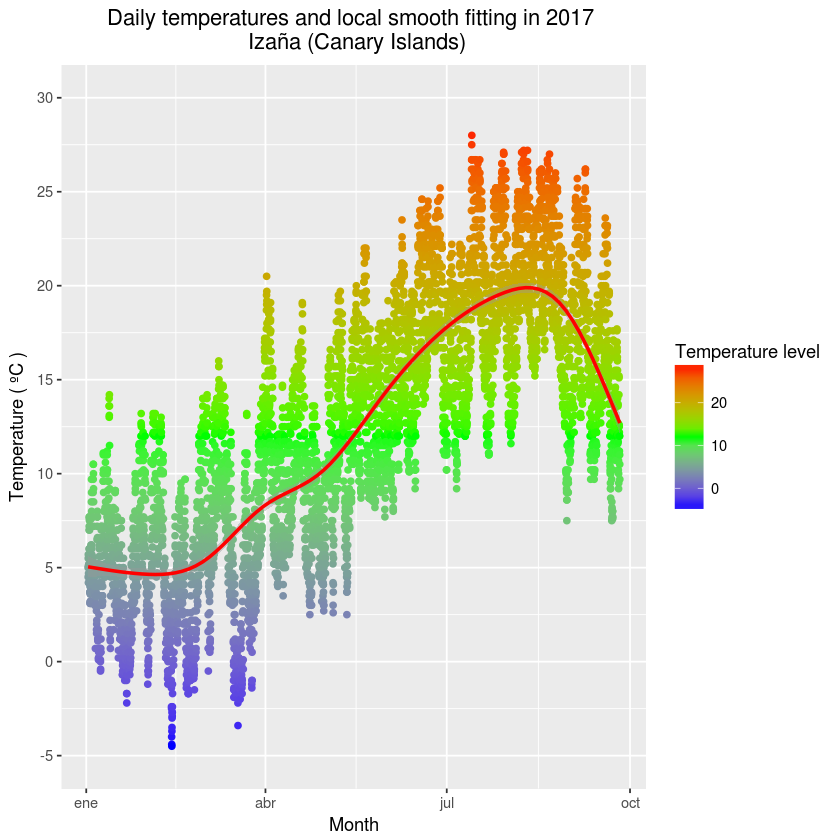

In [8]:
ggplot(temps_at_izana,aes(x = time,y = temp)) + 
  geom_point(aes(colour = temp)) +
  scale_colour_gradient2(name = "Temperature level",low = "blue", mid = "green" , high = "red", midpoint = 12) + 
  geom_smooth(color = "red",size = 1) +
  scale_y_continuous(limits = c(-5,30), breaks = seq(-5,30,5)) +
  ggtitle ("Daily temperatures and local smooth fitting in 2017 \n Izaña (Canary Islands)") +
  xlab("Month") +  ylab ("Temperature ( ºC )") +
  theme(plot.title = element_text(hjust = 0.5))


#### 5.2 Year seasons temperature

We are interested in comparing the pattern of temperatures between the different year seasons. Therefore, we need to compute a season variable by using the zoo library ([Zeileis A. and Grothendieck G., 2005](#zeileis_groth)).

In [9]:
usePackage("zoo")
temps_at_izana$season<-factor(format(as.yearqtr(as.yearmon(temps_at_izana$time, "%m/%d/%Y") + 1/12), "%q"), 
       levels = 1:4, 
       labels = c("winter", "spring", "summer", "fall"))

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [10]:
temps_at_izana %>% group_by(season) %>% summarize(firstDay=min(time),lastDay=max(time))

season,firstDay,lastDay
winter,2017-01-01 22:00:00,2017-02-28 23:00:00
spring,2017-03-01 00:00:00,2017-06-01 00:00:00
summer,2017-06-01 01:00:00,2017-09-01 00:00:00
fall,2017-09-01 01:00:00,2017-09-25 21:00:00


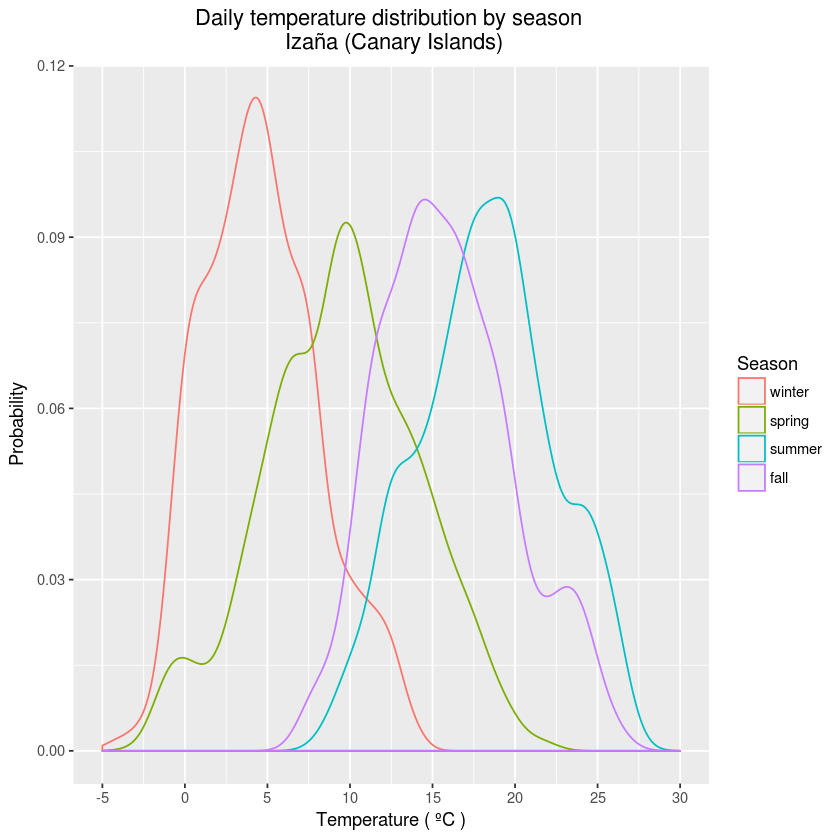

In [11]:
ggplot(temps_at_izana,aes(x = temp, colour = season)) +
  geom_density() +
  scale_x_continuous(limits = c(-5,30), breaks = seq(-5,30,5)) +
  ggtitle ("Daily temperature distribution by season \n Izaña (Canary Islands)") +
  xlab("Temperature ( ºC )") +  ylab ("Probability") + guides(colour=guide_legend(title="Season")) +
  theme(plot.title = element_text(hjust = 0.5))

#### 5.3 Minimum and maximum temperatures

In the next analysis, we obtain the maximum and minimum temperature by day in 2017 and we study the correlation between both variables.

In [12]:
temps_at_izana$day<-format(temps_at_izana$time, "%Y-%m-%d")
temps_at_izana$hour<-format(temps_at_izana$time, "%H:%M")
temps_at_izana_min_max<-temps_at_izana %>%
               group_by(day,season) %>% summarize(min_temp=min(temp),max_temp=max(temp))  

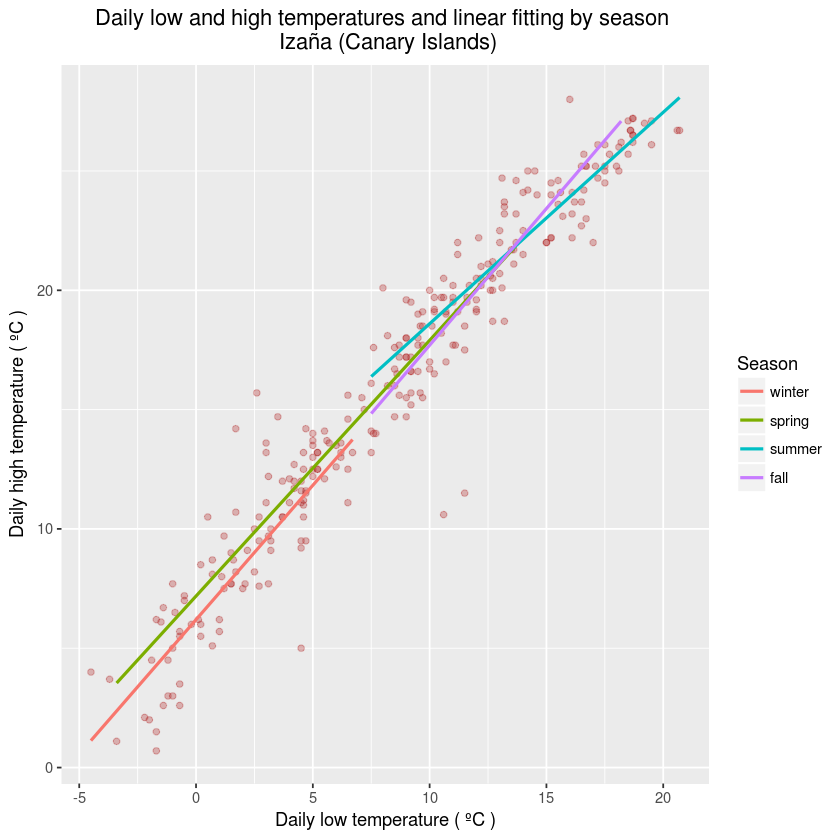

In [13]:
ggplot(temps_at_izana_min_max,aes(x = min_temp, y = max_temp)) +
  geom_point(colour = "firebrick", alpha = 0.3) + 
  geom_smooth(aes(colour = season), method="lm", se= F, size = 0.9) +
  ggtitle ("Daily low and high temperatures and linear fitting by season \n Izaña (Canary Islands)") +
  xlab("Daily low temperature ( ºC )") +  ylab ("Daily high temperature ( ºC )") + 
  guides(colour=guide_legend(title="Season")) +
  theme(plot.title = element_text(hjust = 0.5))

We can also study the distribution of low and high temperatures along the different hours of any day of 2017 in order to compare which parts of the day are more cold or swarm than others. We use, in this case, the reshape library ([Wickham H., 2007](#wickham2)) to arrange data in appropriate way to plot the frequencies of temperatures in the different daily hours.


In [14]:
temps_at_izana_hour_min_max<-left_join(
  temps_at_izana %>%
  select(day,hour,season,temp) %>%
  group_by(day,season) %>% slice(which.max(temp)) %>% rename(max_temp_hour=hour,max_temp=temp),
  temps_at_izana %>%
  select(day,hour,season,temp) %>%
  group_by(day,season) %>% slice(which.min(temp)) %>% rename(min_temp_hour=hour,min_temp=temp) 
) %>% select(day,season,max_temp_hour,min_temp_hour)


Joining, by = c("day", "season")


In [15]:
usePackage("reshape2") 
temps_at_izana_temperatures <- melt(temps_at_izana_hour_min_max,id.vars = c("day","season"),
                     variable.name = "min.max.temp", value.name = "hour")

Loading required package: reshape2


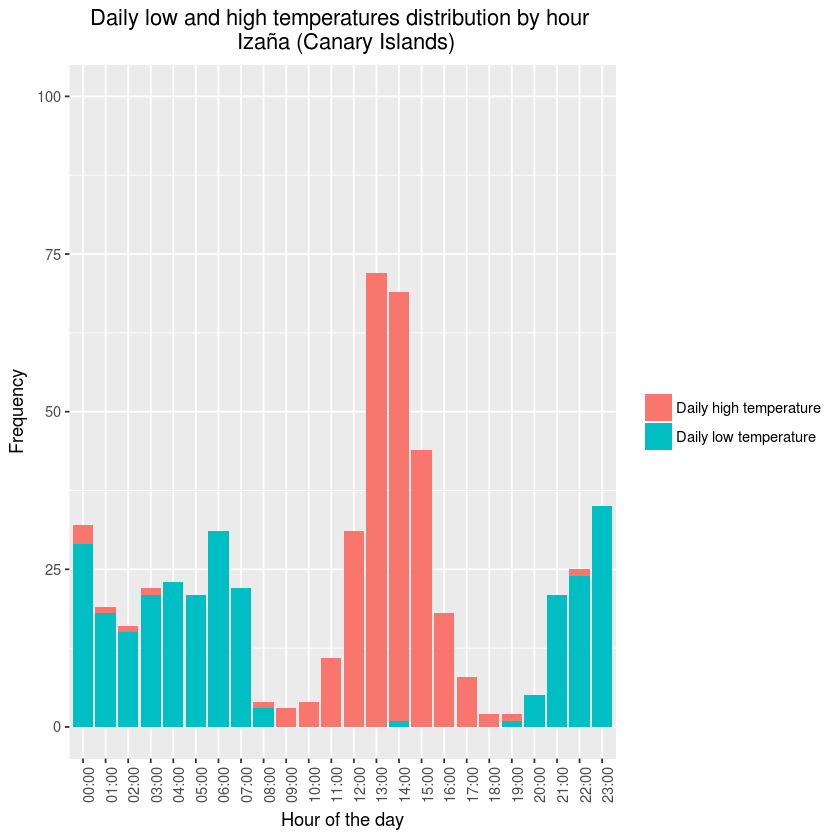

In [16]:
ggplot(temps_at_izana_temperatures) +
  geom_bar(aes(x = hour, fill = min.max.temp)) +
  scale_fill_discrete(name= "", labels = c("Daily high temperature","Daily low temperature")) +
  scale_y_continuous(limits = c(0,100)) +
  ggtitle ("Daily low and high temperatures distribution by hour \n Izaña (Canary Islands)") +
  xlab("Hour of the day") +  ylab ("Frequency") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## 6. Sparklyr

This section considers the sparklyr library that allow us to make a connection to Spark. This connection can be customized by setting the values of certain Spark properties by using the config argument in the spark_connect() function (see [Configuring spark connection in R](#sparklyr))

In [17]:
usePackage("sparklyr")

Loading required package: sparklyr


In [18]:
conf <- spark_config()   # Load variable with spark_config()
conf[["sparklyr.defaultPackages"]] <- NULL
conf$spark.executor.memory <- "16G" 
sc <- spark_connect(master = "local", spark_home="/usr/local/spark",
                    config = conf)

We compute the month from time variable. In particular, we create two variables, the month order and month name.

In [19]:
temps_at_izana$month<-format(temps_at_izana$time, "%m")
temps_at_izana$month_name<-format(temps_at_izana$time, "%B")
head(temps_at_izana)

time,wind_direction,wind_speed,temp,season,day,hour,month,month_name
2017-01-01 22:00:00,260,11.3,5.0,winter,2017-01-01,22:00,01,enero
2017-01-01 23:00:00,250,10.8,4.5,winter,2017-01-01,23:00,01,enero
2017-01-02 00:00:00,260,11.3,5.5,winter,2017-01-02,00:00,01,enero
2017-01-02 01:00:00,260,10.8,5.7,winter,2017-01-02,01:00,01,enero
2017-01-02 02:00:00,250,12.9,5.1,winter,2017-01-02,02:00,01,enero
2017-01-02 03:00:00,250,13.4,4.2,winter,2017-01-02,03:00,01,enero


Then, we copy our data to spark data frame, i.e. a data object in a spark environment.

In [20]:
#db_drop_table(sc, "temps_at_izana")
temps_at_izana <- copy_to(sc, temps_at_izana, "temps_at_izana")
temps_at_izana
src_tbls(sc)

# Source:   table<temps_at_izana> [?? x 9]
# Database: spark_connection
    time wind_direction wind_speed  temp season        day  hour month
   <dbl>          <dbl>      <dbl> <dbl>  <chr>      <chr> <chr> <chr>
 1  2017            260       11.3   5.0 winter 2017-01-01 22:00    01
 2  2017            250       10.8   4.5 winter 2017-01-01 23:00    01
 3  2017            260       11.3   5.5 winter 2017-01-02 00:00    01
 4  2017            260       10.8   5.7 winter 2017-01-02 01:00    01
 5  2017            250       12.9   5.1 winter 2017-01-02 02:00    01
 6  2017            250       13.4   4.2 winter 2017-01-02 03:00    01
 7  2017            250       13.4   4.7 winter 2017-01-02 04:00    01
 8  2017            260       12.3   4.2 winter 2017-01-02 05:00    01
 9  2017            260       12.3   4.6 winter 2017-01-02 06:00    01
10  2017            260       11.8   5.2 winter 2017-01-02 07:00    01
# ... with more rows, and 1 more variables: month_name <chr>

[1] "temps_at_izana"

Now, we can make the typical lazy spark operations. The following sequence of operations  actually does not touch the database. It’s not until data are asked (e.g. by printing temps_at_izana_avg) that dplyr requests the results from the database. 

In [21]:
temps_at_izana_avg<-temps_at_izana %>%
  group_by(month,month_name) %>%
  summarize(avg_wind=mean(wind_speed),avg_temp=mean(temp))
temps_at_izana_avg

# Source:   lazy query [?? x 4]
# Database: spark_connection
# Groups:   month
  month month_name avg_wind  avg_temp
  <chr>      <chr>    <dbl>     <dbl>
1    01      enero 9.073950  4.790476
2    02    febrero 7.803506  4.460518
3    03      marzo 7.712921  6.617900
4    04      abril 8.182260  9.586409
5    05       mayo 7.343103 12.443966
6    06      junio 5.969795 16.686657
7    07      julio 5.105517 18.588828
8    08     agosto 6.231077 19.353729
9    09 septiembre 7.713445 15.890588

Finally, we use the collect() function to execute the Spark query and return the results to R.

In [22]:
temps_at_izana_avg <- collect(temps_at_izana_avg)
temps_at_izana_avg

month,month_name,avg_wind,avg_temp
01,enero,9.073950,4.790476
02,febrero,7.803506,4.460518
03,marzo,7.712921,6.617900
04,abril,8.182260,9.586409
05,mayo,7.343103,12.443966
06,junio,5.969795,16.686657
07,julio,5.105517,18.588828
08,agosto,6.231077,19.353729
09,septiembre,7.713445,15.890588


## 7. References

<a id='iannone'></a>Iannone R. (2015). stationaRy: Get Hourly Meteorological Data from Global Stations. R package version
0.4.1, URL https://CRAN.R-project.org/package=stationaRy.

<a id='kahle_wickham'></a>Kahle D. and Wickham H. (2013) ggmap: Spatial Visualization with ggplot2. The R Journal, 5(1), 144-161, URL http://journal.r-project.org/archive/2013-1/kahle-wickham.pdf

<a id='sparklyr'></a>Rstudio web page. Configuring Spark connection from R using sparklyr library, URL https://spark.rstudio.com/guides/connections/.

<a id='wickham1'></a>Wickham H. (2009). ggplot2: Elegant Graphics for Data Analysis, Springer-Verlag, New York, URL http://ggplot2.org.

<a id='wickham2'></a>Wickham H. (2007). Reshaping Data with the reshape Package, Journal of Statistical Software, 21(12), pp. 1-20. URL http://www.jstatsoft.org/v21/i12/

<a id='wickham_et_al'></a>Wickham H., Francois R., Henry L. and Müller K. (2017). dplyr: A Grammar of Data Manipulation. R package version
0.7.3, URL https://CRAN.R-project.org/package=dplyr.

<a id='zeileis_groth'></a>Zeileis A. and Grothendieck G. (2005). zoo: S3 Infrastructure for Regular and Irregular Time Series. Journal of Statistical Software, 14(6), pp. 1-27.

